In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
TITLE_FONT = {'fontname': 'Arial', 'fontsize': 12, 'fontweight': 'bold'}
smaller_font = {'fontname': 'Arial', 'fontsize': 10, 'fontweight': 'normal'}
tiny_fontsize = 8
micro_fontsize = 5
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
#T related
r = 0.1 # bowl radius
c = 4.2e3 #specific heat capacity of soup
rho = 1e3 # density of soup
l = 0.03 # soup height
h_side = 50 # natural convection coefficient through side
h_top = 50 # natural convection coefficient through top
hob_rate = 7 # hob rate as shown on the hob
# P = 1 # PWM percentage for pot on hob
T_inf = 20 # room temperature

Q_in = 4.88 * 2 ** hob_rate # heat addition rate per unit time


T0 = T_inf

#G related
G_0 = 0.8e-3
alpha_G = 0.8
beta_G = 0.025
gamma_G = 54

#pH related
beta_pH = 0.00585
gamma_pH = 0.9

#n_s related
alpha_t = 10**(-3.5)
k_1 = 0.0001
k_2 = 0.005
k = 1e-6
V_s = 1

def f_G(G_raw, T):
    return G_raw
    c = 0.2
    rate = 0.02    
    return (-c*np.exp(-rate*(T-25))+(c+1)) * G_raw

def simulationStandard(Q, index, salt, vinegar, V_t = 0.4, dt = 0.1):
    alpha_t = 10**(-3.5)
    t = G = pH = n_s = m_s = m_v = 0
    T = T0
    t_total = len(Q) * dt
    counter = 0
    data = []
    salt = salt * 1e-3 # in kg
    vinegar = vinegar * 1e-2 # in kg
    
    
    while t < t_total:
        t += dt
        T += 1/(c*rho*l*math.pi*r**2)*(-(T-T_inf)*(h_top*math.pi*r**2 + 2*h_side*math.pi*r*l) + Q[counter]) * dt
        G_raw = G_0 + alpha_G*m_s + beta_G*m_v + gamma_G*n_s
        G = f_G(G_raw, T)
        n_s += k_1*np.exp(k_2*(T-25))*(alpha_t - n_s*(1/V_t + 1/V_s))
        pH = -np.log10(10e-7 + beta_pH*m_v + gamma_pH*n_s)
        if round(t, 1) in index:
            m_s += float(salt[np.where(index == round(t, 1))])
            m_v += float(vinegar[np.where(index == round(t, 1))])
#             print("m_s, m_v:", m_s, m_v)
        
        counter += 1
        data.append([t, T, G, pH, n_s])

    return np.array(data)

In [48]:
Q = np.array([1]*5000 + [0.25]*5000) * 4.88*2**7
index = np.array([300, 400, 500])
salt = np.array([1, 1, 1])
vinegar = np.array([1, 1, 1])

targetData = simulationStandard(Q, index, salt, vinegar, 0.4)
target_t = targetData[:,0]
target_T = targetData[:,1]
target_G = targetData[:,2]
target_pH = targetData[:,3]

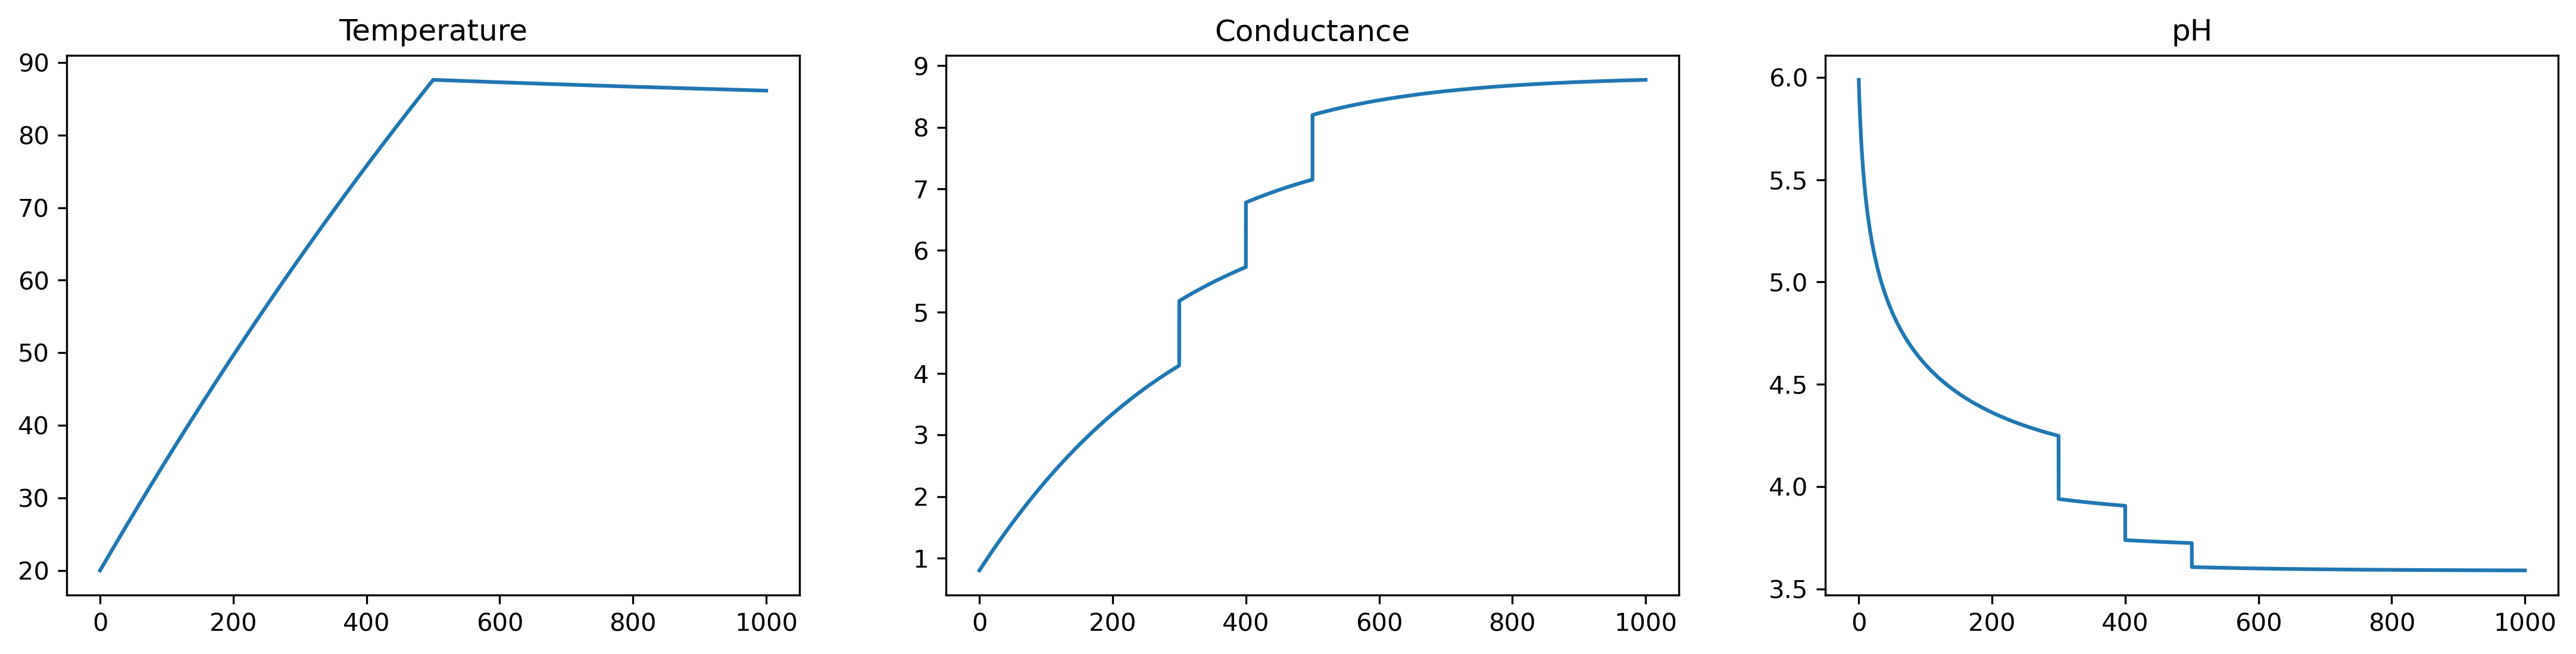

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
ax1.set_title("Temperature")
ax2.set_title("Conductance")
ax3.set_title("pH")

ax1.plot(targetData[:,0], targetData[:,1])
ax2.plot(targetData[:,0], targetData[:,2]*1000)
ax3.plot(targetData[:,0], targetData[:,3])

In [5]:
Kp = np.array([
    [0.8,0,0],
    [0,1.5,0],
    [0,0,0.07]
])

Ki = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0]
])

Kd = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0]
])

target_t = targetData[:,0]
target_T = targetData[:,1]
target_G = targetData[:,2]
target_pH = targetData[:,3]

def controller_PID(Kp, Ki, Kd):
    V_t = 0.4
    dt = 0.1
    t_total = 1000
    alpha_t = 10**(-3.5)
    t = G = pH = n_s = m_s = m_v = 0
    T = T0
    T_discrete = 30
    discrete_counter = 300

    counter = 0
    
    data = np.array([[0]*5]) # t, T, G, pH, n_s
    error = np.array([[0]*3]) # error_T, error_G, error_pH
    control_input = np.array([[0]*3]) # Q_in, m_s, m_v
    Qin_cap = 4.88*2**7
    Q_in_array = [Qin_cap]*discrete_counter

    
    while t < t_total:
        t += dt
        T += 1/(c*rho*l*math.pi*r**2)*(-(T-T_inf)*(h_top*math.pi*r**2 + 2*h_side*math.pi*r*l) + Q_in_array[counter % 300]) * dt
        n_s += k_1*np.exp(k_2*(T-25))*(alpha_t - n_s*(1/V_t + 1/V_s))
        G_raw = G_0 + alpha_G*m_s + beta_G*m_v + gamma_G*n_s
        G = f_G(G_raw, T)
        pH = -np.log10(10e-7 + beta_pH*m_v + gamma_pH*n_s)
        
        if counter % discrete_counter == 0:
            error = np.append(error, [[target_T[counter] - T, target_G[counter] - G, pH - target_pH[counter]]], axis = 0)

            if counter / discrete_counter > 0:
                ep = error[-1]
                if counter / discrete_counter > 3:
                    ei = np.sum(error[-4:], axis = 0) * T_discrete
                else:
                    ei = np.sum(error, axis = 0) * T_discrete
                
                ed = (error[-1] - error[-2]) / T_discrete
                u = Kp.dot(ep) + Ki.dot(ei) + Kd.dot(ed)
                Q_in = np.clip(u[0], 0, 1)
                Q_in_array = ([Qin_cap] * int(discrete_counter*Q_in) + [0] * (discrete_counter - int(discrete_counter*Q_in)))
                s_in = np.max([0, u[1]])
                v_in = np.max([0, u[2]])
                m_s += s_in
                m_v += v_in
                control_input = np.append(control_input, [[Q_in, s_in, v_in]], axis = 0)

        data = np.append(data, [[t, T, G, pH, n_s]], axis=0)
        counter += 1
        
    return data, error, control_input

In [6]:
Kp = np.array([
    [0.39,0,0],
    [0,1.0,0],
    [0,0,0.041]
])

Ki = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0]
])

Kd = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0]
])

data, error, control_input = controller_PID(Kp, Ki, Kd)

t_PID = data[:,0]
T_PID = data[:,1]
G_PID = data[:,2]
pH_PID = data[:,3]
n_s_PID = data[:,4]

error_T_PID = error[:,0]
error_G_PID = error[:,1]
error_pH_PID = error[:,2]
control_Q = control_input[:,0]
control_s = control_input[:,1]
control_v = control_input[:,2]


k1 = 0.01
k2 = 1
k3 = 20

print(np.average(error_T_PID**2), np.average((error_G_PID*1000)**2), np.average(error_pH_PID**2))
print(np.average(error_T_PID**2) * k1, np.average((error_G_PID*1000)**2)*k2, np.average(error_pH_PID**2)*k3)
print(np.average(error_T_PID**2) * k1 + np.average((error_G_PID*1000)**2)*k2 + np.average(error_pH_PID**2)*k3)

7.667607765006372 0.0935186215012831 0.003957730358693377
0.07667607765006372 0.0935186215012831 0.07915460717386753
0.24934930632521435


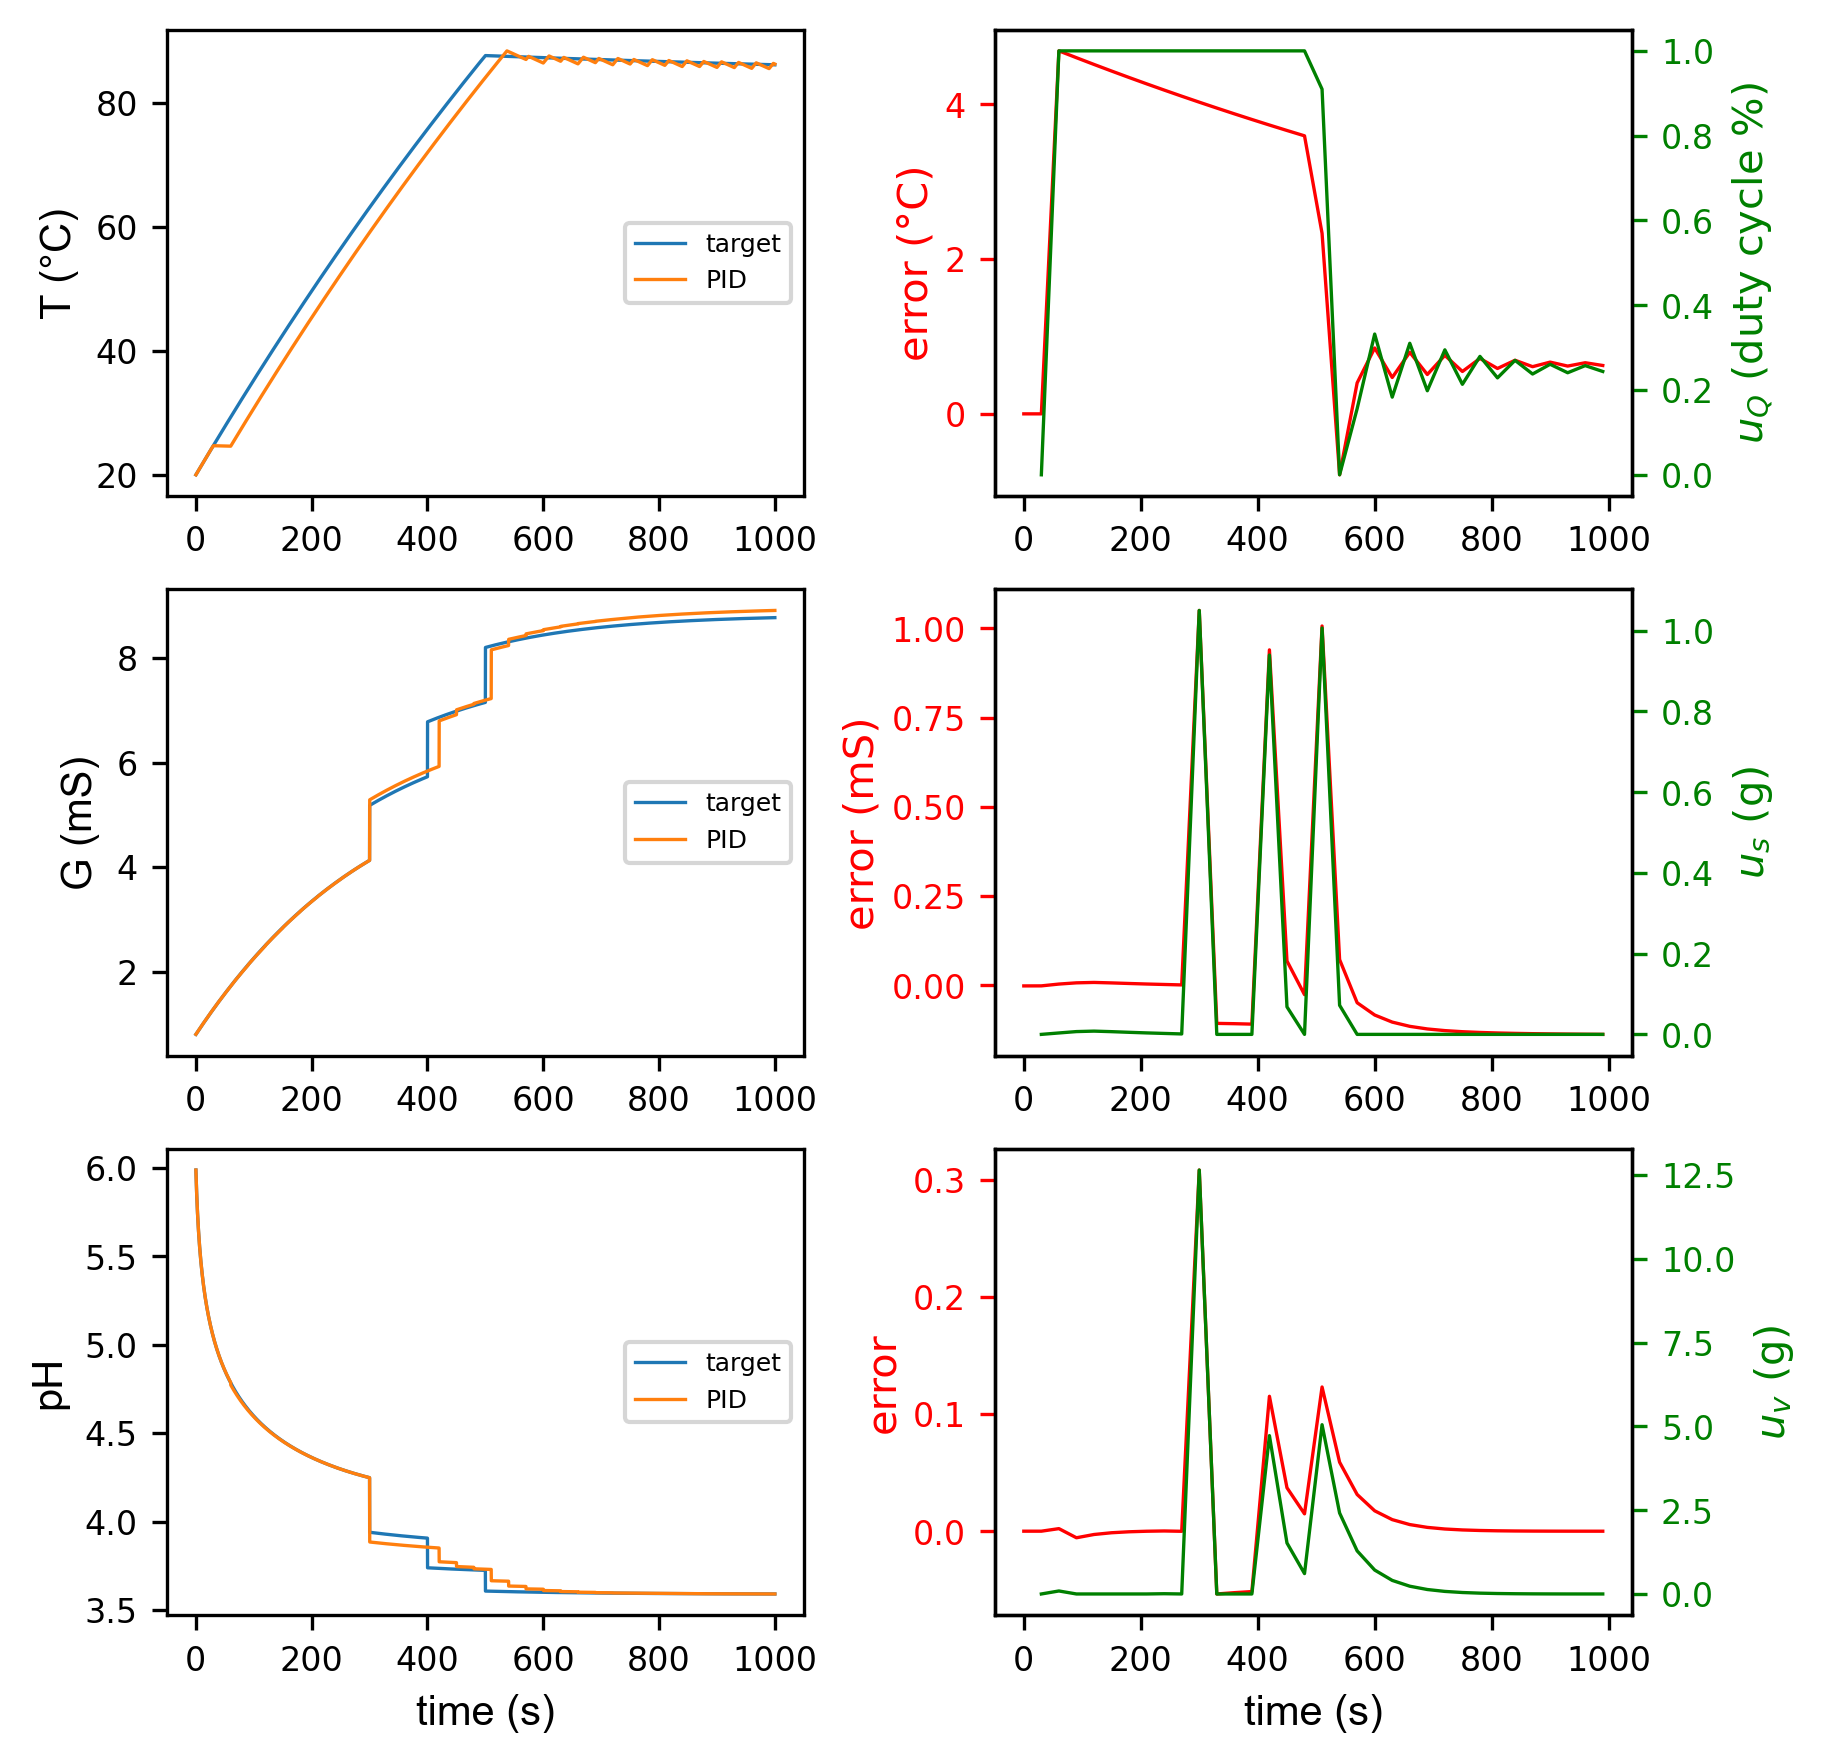

In [7]:
plotwidth = 0.8

fig, axs = plt.subplots(3, 2, figsize=(6.3, 7))
axs[0, 0].plot(target_t, target_T, label = "target", linewidth = plotwidth)
axs[0, 0].plot(t_PID[1:], T_PID[1:], label = "PID", linewidth = plotwidth)
axs[0, 0].tick_params(axis='x', labelsize = tiny_fontsize)
axs[0, 0].tick_params(axis='y', labelsize = tiny_fontsize)
axs[0, 0].set_ylabel('T (°C)', **smaller_font)
axs[0, 0].legend(fontsize = tiny_fontsize - 2, loc = 'center right')
axs[0, 1].plot(t_PID[1::300], error_T_PID[1:], linewidth = plotwidth, color = "Red")
axs[0, 1].set_ylabel("error (°C)", color = "Red", labelpad = 2)
axs[0, 1].tick_params(axis='x', labelsize = tiny_fontsize)
axs[0, 1].tick_params(axis='y', colors = "Red", labelsize = tiny_fontsize)

ax02 = axs[0, 1].twinx()
ax02.plot(t_PID[1::300][1:], control_Q[1:], linewidth = plotwidth, color = "Green")
ax02.set_ylabel('$u_{Q}$ (duty cycle %)', color = "Green")
ax02.tick_params(axis='y', colors = "Green", labelsize = tiny_fontsize)

axs[1, 0].plot(target_t, target_G*1000, label = "target", linewidth = plotwidth)
axs[1, 0].plot(t_PID[1:], G_PID[1:]*1000, label = "PID", linewidth = plotwidth)
axs[1, 0].tick_params(axis='x', labelsize = tiny_fontsize)
axs[1, 0].tick_params(axis='y', labelsize = tiny_fontsize)
axs[1, 0].set_ylabel('G (mS)', **smaller_font)
axs[1, 0].legend(fontsize = tiny_fontsize - 2, loc = 'center right')
axs[1, 1].plot(t_PID[1::300], error_G_PID[1:]*1000, linewidth = plotwidth, color = "Red")
axs[1, 1].set_ylabel("error (mS)", color = "Red", labelpad = 2)
axs[1, 1].tick_params(axis='x', labelsize = tiny_fontsize)
axs[1, 1].tick_params(axis='y', colors = "Red", labelsize = tiny_fontsize)

ax12 = axs[1, 1].twinx()
ax12.plot(t_PID[1::300][1:], control_s[1:]*1000, linewidth = plotwidth, color = "Green")
ax12.set_ylabel('$u_{s}$ (g)', color = "Green")
ax12.tick_params(axis='y', colors = "Green", labelsize = tiny_fontsize)

axs[2, 0].plot(target_t, target_pH, label = "target", linewidth = plotwidth)
axs[2, 0].plot(t_PID[1:], pH_PID[1:], label = "PID", linewidth = plotwidth)
axs[2, 0].tick_params(axis='x', labelsize = tiny_fontsize)
axs[2, 0].tick_params(axis='y', labelsize = tiny_fontsize)
axs[2, 0].set_ylabel('pH', **smaller_font)
axs[2, 0].set_xlabel('time (s)', **smaller_font)
axs[2, 0].legend(fontsize = tiny_fontsize - 2, loc = 'center right')
axs[2, 1].plot(t_PID[1::300], error_pH_PID[1:], linewidth = plotwidth, color = "Red")
axs[2, 1].set_ylabel("error", color = "Red", labelpad = 2)
axs[2, 1].set_xlabel('time (s)', **smaller_font)
axs[2, 1].tick_params(axis='x', labelsize = tiny_fontsize)
axs[2, 1].tick_params(axis='y', colors = "Red", labelsize = tiny_fontsize)

ax22 = axs[2, 1].twinx()
ax22.plot(t_PID[1::300][1:], control_v[1:]*1000, linewidth = plotwidth, color = "Green")
ax22.set_ylabel('$u_{v}$ (g)', color = "Green")
ax22.tick_params(axis='y', colors = "Green", labelsize = tiny_fontsize)

plt.subplots_adjust(wspace=0.3)

In [8]:
Kp = np.array([
    [0.39,0,0],
    [0,1.0,0],
    [0,0,0.041]
])

Ki = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0]
])

Kd = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0]
])

data, error, control_input = controller_PID(Kp, Ki, Kd)

t_PID = data[:,0]
T_PID = data[:,1]
G_PID = data[:,2]
pH_PID = data[:,3]
n_s_PID = data[:,4]

error_T_PID = error[:,0]
error_G_PID = error[:,1]
error_pH_PID = error[:,2]
control_Q = control_input[:,0]
control_s = control_input[:,1]
control_v = control_input[:,2]


k1 = 0.01
k2 = 1
k3 = 20

print(np.average(error_T_PID**2), np.average((error_G_PID*1000)**2), np.average(error_pH_PID**2))
print(np.average(error_T_PID**2) * k1, np.average((error_G_PID*1000)**2)*k2, np.average(error_pH_PID**2)*k3)
print(np.average(error_T_PID**2) * k1 + np.average((error_G_PID*1000)**2)*k2 + np.average(error_pH_PID**2)*k3)

7.667607765006372 0.0935186215012831 0.003957730358693377
0.07667607765006372 0.0935186215012831 0.07915460717386753
0.24934930632521435


Text(0.5, 1.0, 'pH_control')

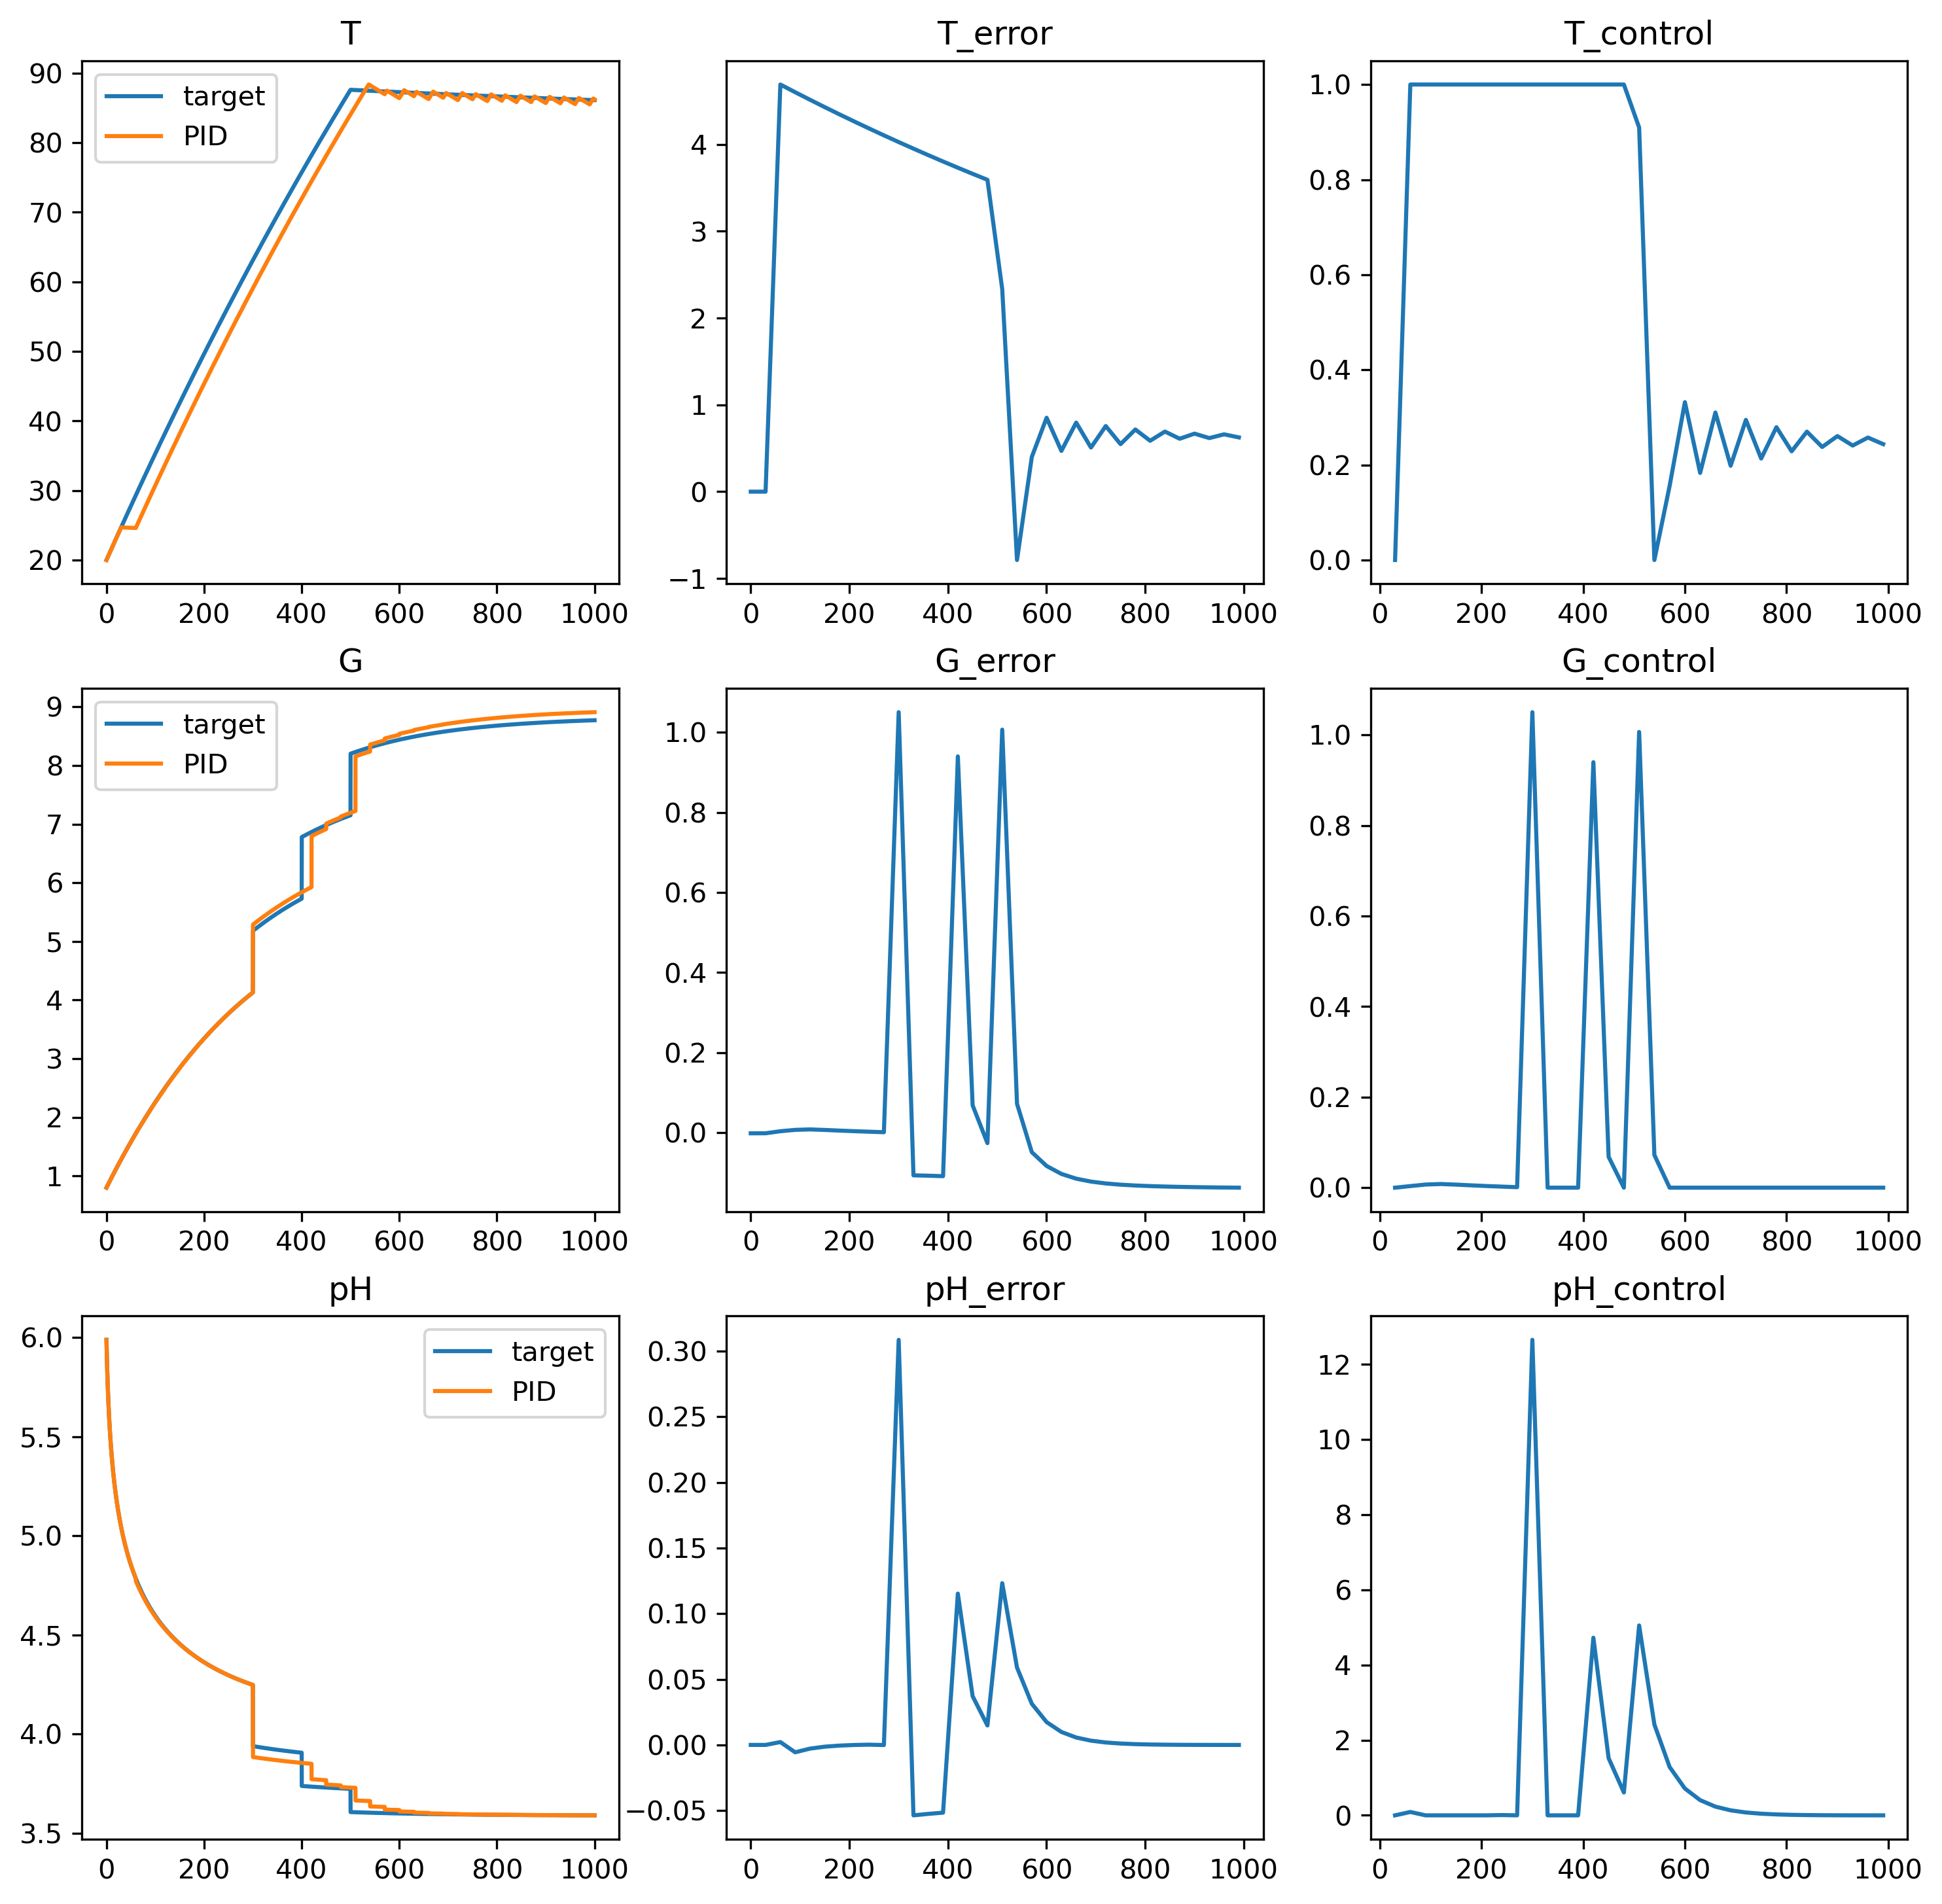

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs[0, 0].plot(target_t, target_T, label = "target")
axs[0, 0].plot(t_PID[1:], T_PID[1:], label = "PID")
axs[0, 0].set_title('T')
axs[0, 0].legend()
axs[0, 1].plot(t_PID[1::300], error_T_PID[1:])
axs[0, 1].set_title('T_error')
axs[0, 2].plot(t_PID[1::300][1:], control_Q[1:])
axs[0, 2].set_title('T_control')

axs[1, 0].plot(target_t, target_G*1000, label = "target")
axs[1, 0].plot(t_PID[1:], G_PID[1:]*1000, label = "PID")
axs[1, 0].set_title('G')
axs[1, 0].legend()
axs[1, 1].plot(t_PID[1::300], error_G_PID[1:]*1000)
axs[1, 1].set_title('G_error')
axs[1, 2].plot(t_PID[1::300][1:], control_s[1:]*1000)
axs[1, 2].set_title('G_control')

axs[2, 0].plot(target_t, target_pH, label = "target")
axs[2, 0].plot(t_PID[1:], pH_PID[1:], label = "PID")
axs[2, 0].set_title('pH')
axs[2, 0].legend()
axs[2, 1].plot(t_PID[1::300], error_pH_PID[1:])
axs[2, 1].set_title('pH_error')
axs[2, 2].plot(t_PID[1::300][1:], control_v[1:]*1000)
axs[2, 2].set_title('pH_control')

In [44]:
for n in np.linspace(2.2, 2.5, 50):

    Kp = np.array([
        [0.39,0,0],
        [0,1.0,0],
        [0,0,0.041]
    ])

    Ki = np.array([
        [2.2e-3,0,0],
        [0,-9.3e-4,0],
        [0,0,7.1e-5]
    ])

    Kd = np.array([
        [0.010,0,0],
        [0,2.3,0],
        [0,0,-0.22]
    ])

    data, error, control_input = controller_PID(Kp, Ki, Kd)

    t_PID = data[:,0]
    T_PID = data[:,1]
    G_PID = data[:,2]
    pH_PID = data[:,3]
    n_s_PID = data[:,4]

    error_T_PID = error[:,0]
    error_G_PID = error[:,1]
    error_pH_PID = error[:,2]
    control_Q = control_input[:,0]
    control_s = control_input[:,1]
    control_v = control_input[:,2]


    k1 = 0.01
    k2 = 1
    k3 = 20

#     print(n, np.average(error_T_PID**2), np.average((error_G_PID*1000)**2), np.average(error_pH_PID**2))
    print(n, np.average(error_T_PID**2) * k1 + np.average((error_G_PID*1000)**2)*k2 + np.average(error_pH_PID**2)*k3)

2.2 0.24112049251064266
2.206122448979592 0.24111913311072253
2.212244897959184 0.24111783645620094
2.2183673469387757 0.2411166025470728
2.2244897959183674 0.24111543138333263
2.2306122448979595 0.24111432296497542
2.236734693877551 0.24111327729199622
2.242857142857143 0.24111229436438958
2.248979591836735 0.2411113741821504
2.2551020408163267 0.2411105167452735
2.2612244897959184 0.2411097220537538
2.2673469387755105 0.24110899010758607
2.273469387755102 0.24110832090676515
2.279591836734694 0.2411077144512861
2.285714285714286 0.24110717074114324
2.2918367346938777 0.24110668977633193
2.2979591836734694 0.24110627155684689
2.3040816326530615 0.241105916082683
2.3102040816326532 0.24110562335383495
2.316326530612245 0.24110539337029763
2.322448979591837 0.24110522613206603
2.3285714285714287 0.2411051216391349
2.3346938775510204 0.24110507989149887
2.3408163265306126 0.24110510088915338
2.3469387755102042 0.24110518463209285
2.353061224489796 0.24110533112031235
2.3591836734693876 0

In [45]:
Kp = np.array([
    [0.39,0,0],
    [0,1.0,0],
    [0,0,0.041]
])

Ki = np.array([
    [2.2e-3,0,0],
    [0,-9.3e-4,0],
    [0,0,7.1e-5]
])

Kd = np.array([
    [0.010,0,0],
    [0,2.3,0],
    [0,0,-0.22]
])

data, error, control_input = controller_PID(Kp, Ki, Kd)

t_PID = data[:,0]
T_PID = data[:,1]
G_PID = data[:,2]
pH_PID = data[:,3]
n_s_PID = data[:,4]

error_T_PID = error[:,0]
error_G_PID = error[:,1]
error_pH_PID = error[:,2]
control_Q = control_input[:,0]
control_s = control_input[:,1]
control_v = control_input[:,2]


k1 = 0.01
k2 = 1
k3 = 20

print(np.average(error_T_PID**2), np.average((error_G_PID*1000)**2), np.average(error_pH_PID**2))
print(np.average(error_T_PID**2) * k1, np.average((error_G_PID*1000)**2)*k2, np.average(error_pH_PID**2)*k3)
print(np.average(error_T_PID**2) * k1 + np.average((error_G_PID*1000)**2)*k2 + np.average(error_pH_PID**2)*k3)

7.600649769411153 0.08784753486262739 0.0038620986939877787
0.07600649769411154 0.08784753486262739 0.07724197387975558
0.24109600643649448


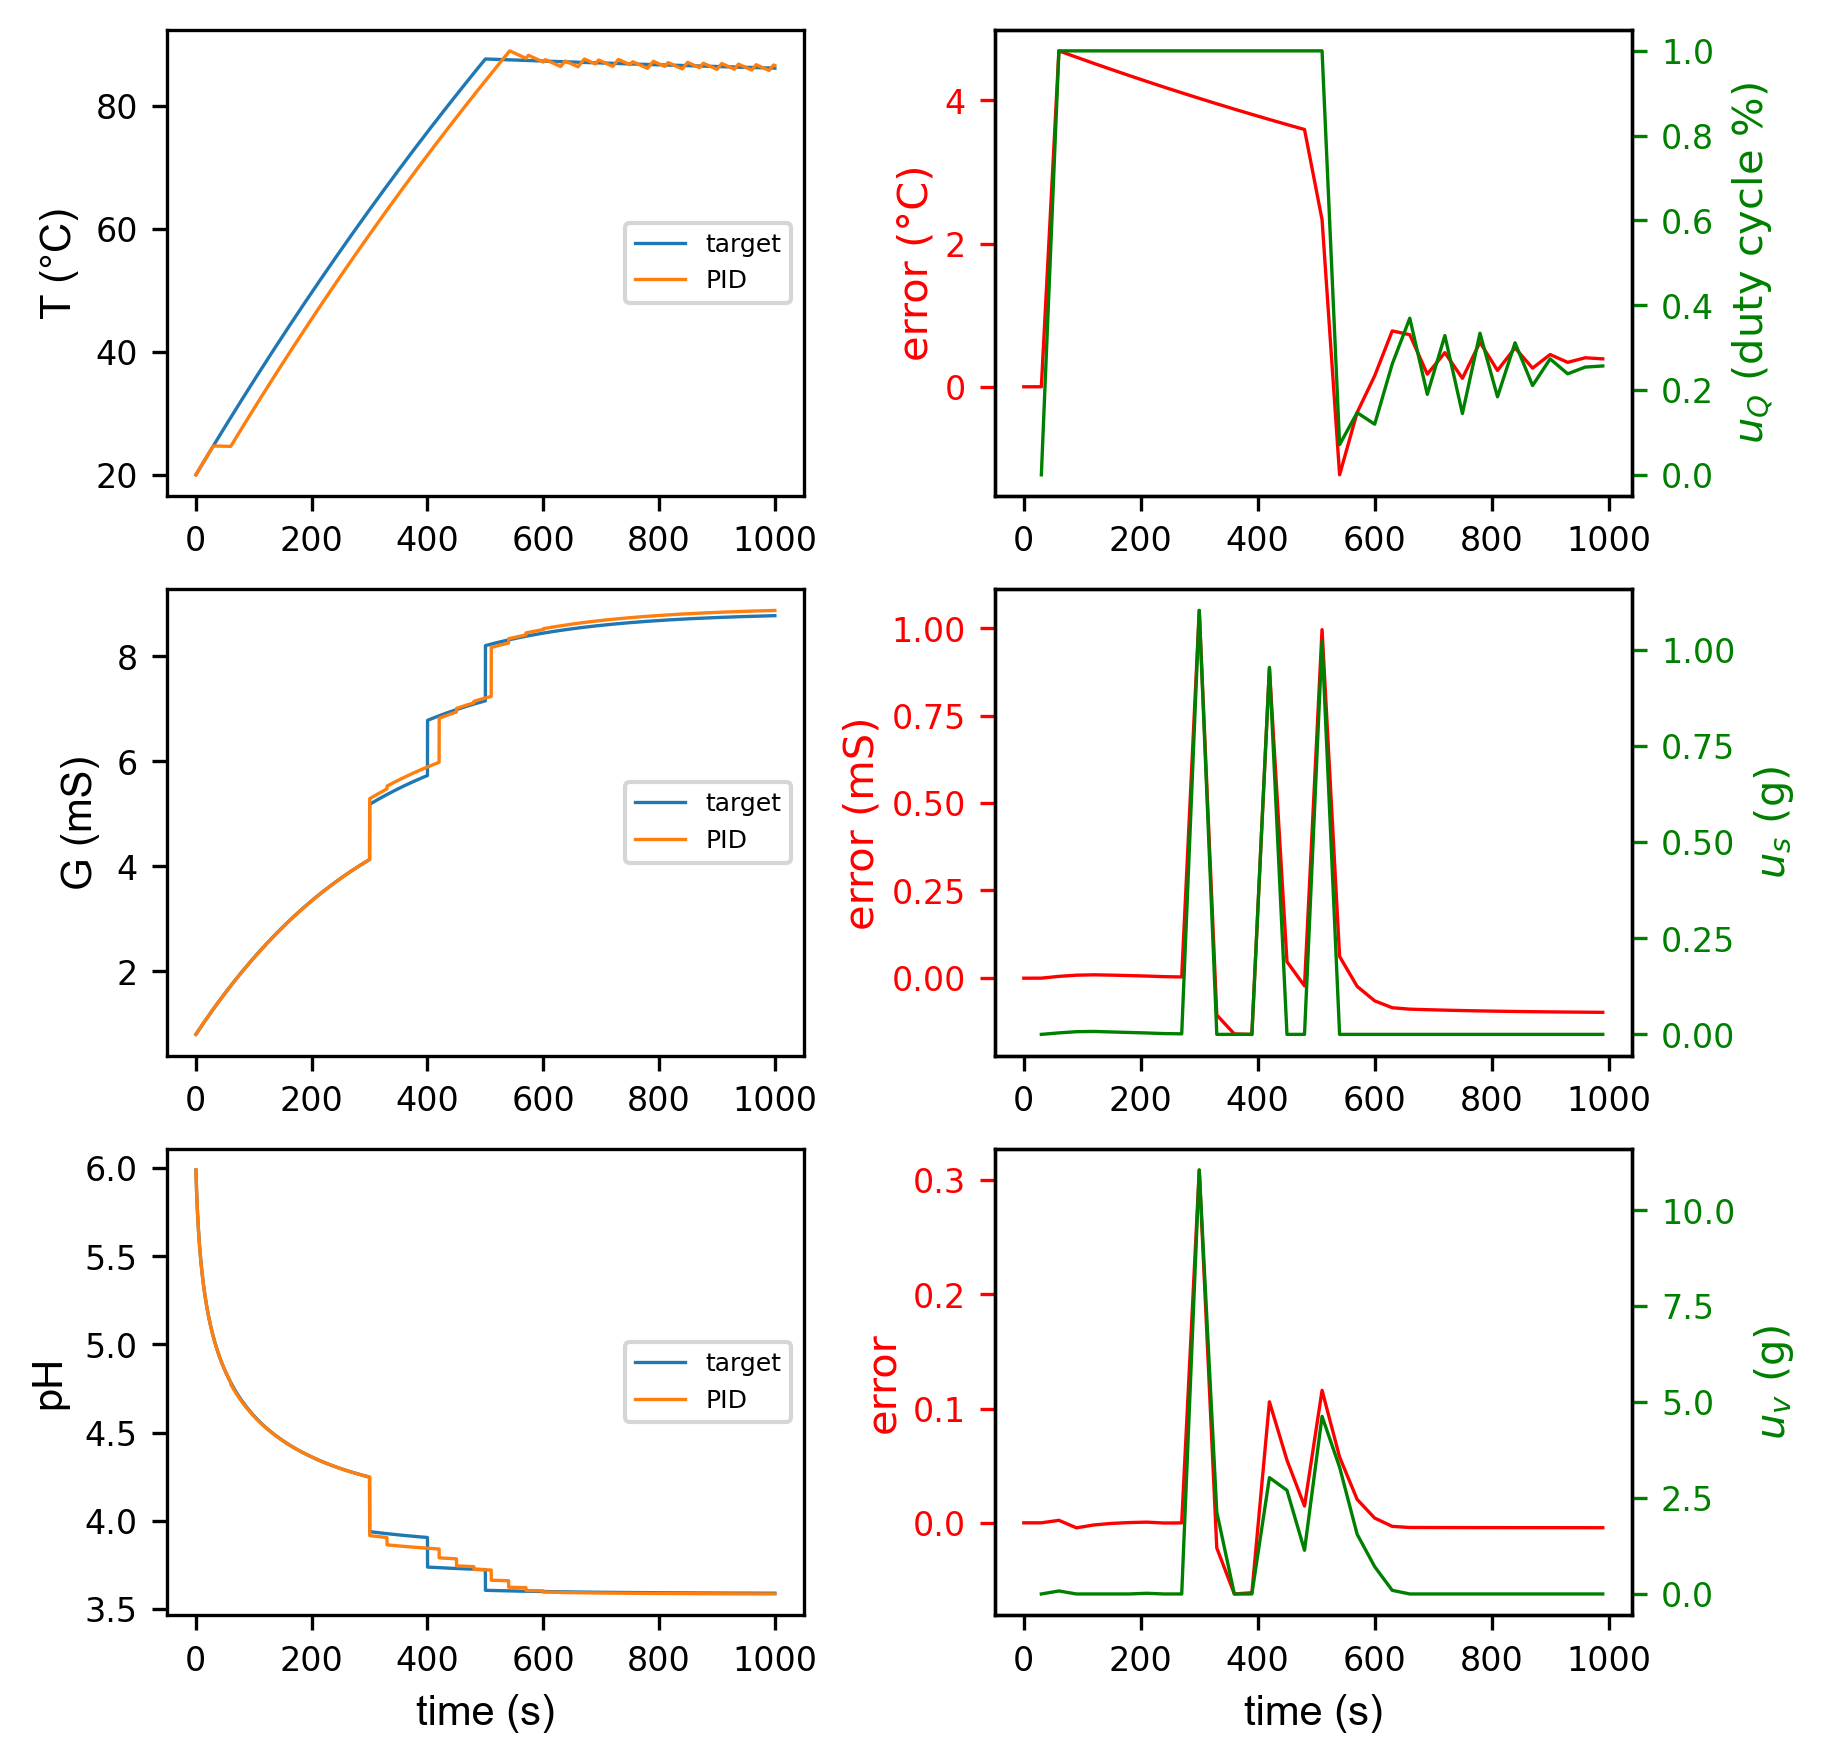

In [47]:
plotwidth = 0.8

fig, axs = plt.subplots(3, 2, figsize=(6.3, 7))
axs[0, 0].plot(target_t, target_T, label = "target", linewidth = plotwidth)
axs[0, 0].plot(t_PID[1:], T_PID[1:], label = "PID", linewidth = plotwidth)
axs[0, 0].tick_params(axis='x', labelsize = tiny_fontsize)
axs[0, 0].tick_params(axis='y', labelsize = tiny_fontsize)
axs[0, 0].set_ylabel('T (°C)', **smaller_font)
axs[0, 0].legend(fontsize = tiny_fontsize - 2, loc = 'center right')
axs[0, 1].plot(t_PID[1::300], error_T_PID[1:], linewidth = plotwidth, color = "Red")
axs[0, 1].set_ylabel("error (°C)", color = "Red", labelpad = 2)
axs[0, 1].tick_params(axis='x', labelsize = tiny_fontsize)
axs[0, 1].tick_params(axis='y', colors = "Red", labelsize = tiny_fontsize)

ax02 = axs[0, 1].twinx()
ax02.plot(t_PID[1::300][1:], control_Q[1:], linewidth = plotwidth, color = "Green")
ax02.set_ylabel('$u_{Q}$ (duty cycle %)', color = "Green")
ax02.tick_params(axis='y', colors = "Green", labelsize = tiny_fontsize)

axs[1, 0].plot(target_t, target_G*1000, label = "target", linewidth = plotwidth)
axs[1, 0].plot(t_PID[1:], G_PID[1:]*1000, label = "PID", linewidth = plotwidth)
axs[1, 0].tick_params(axis='x', labelsize = tiny_fontsize)
axs[1, 0].tick_params(axis='y', labelsize = tiny_fontsize)
axs[1, 0].set_ylabel('G (mS)', **smaller_font)
axs[1, 0].legend(fontsize = tiny_fontsize - 2, loc = 'center right')
axs[1, 1].plot(t_PID[1::300], error_G_PID[1:]*1000, linewidth = plotwidth, color = "Red")
axs[1, 1].set_ylabel("error (mS)", color = "Red", labelpad = 2)
axs[1, 1].tick_params(axis='x', labelsize = tiny_fontsize)
axs[1, 1].tick_params(axis='y', colors = "Red", labelsize = tiny_fontsize)

ax12 = axs[1, 1].twinx()
ax12.plot(t_PID[1::300][1:], control_s[1:]*1000, linewidth = plotwidth, color = "Green")
ax12.set_ylabel('$u_{s}$ (g)', color = "Green")
ax12.tick_params(axis='y', colors = "Green", labelsize = tiny_fontsize)

axs[2, 0].plot(target_t, target_pH, label = "target", linewidth = plotwidth)
axs[2, 0].plot(t_PID[1:], pH_PID[1:], label = "PID", linewidth = plotwidth)
axs[2, 0].tick_params(axis='x', labelsize = tiny_fontsize)
axs[2, 0].tick_params(axis='y', labelsize = tiny_fontsize)
axs[2, 0].set_ylabel('pH', **smaller_font)
axs[2, 0].set_xlabel('time (s)', **smaller_font)
axs[2, 0].legend(fontsize = tiny_fontsize - 2, loc = 'center right')
axs[2, 1].plot(t_PID[1::300], error_pH_PID[1:], linewidth = plotwidth, color = "Red")
axs[2, 1].set_ylabel("error", color = "Red", labelpad = 2)
axs[2, 1].set_xlabel('time (s)', **smaller_font)
axs[2, 1].tick_params(axis='x', labelsize = tiny_fontsize)
axs[2, 1].tick_params(axis='y', colors = "Red", labelsize = tiny_fontsize)

ax22 = axs[2, 1].twinx()
ax22.plot(t_PID[1::300][1:], control_v[1:]*1000, linewidth = plotwidth, color = "Green")
ax22.set_ylabel('$u_{v}$ (g)', color = "Green")
ax22.tick_params(axis='y', colors = "Green", labelsize = tiny_fontsize)

plt.subplots_adjust(wspace=0.3)

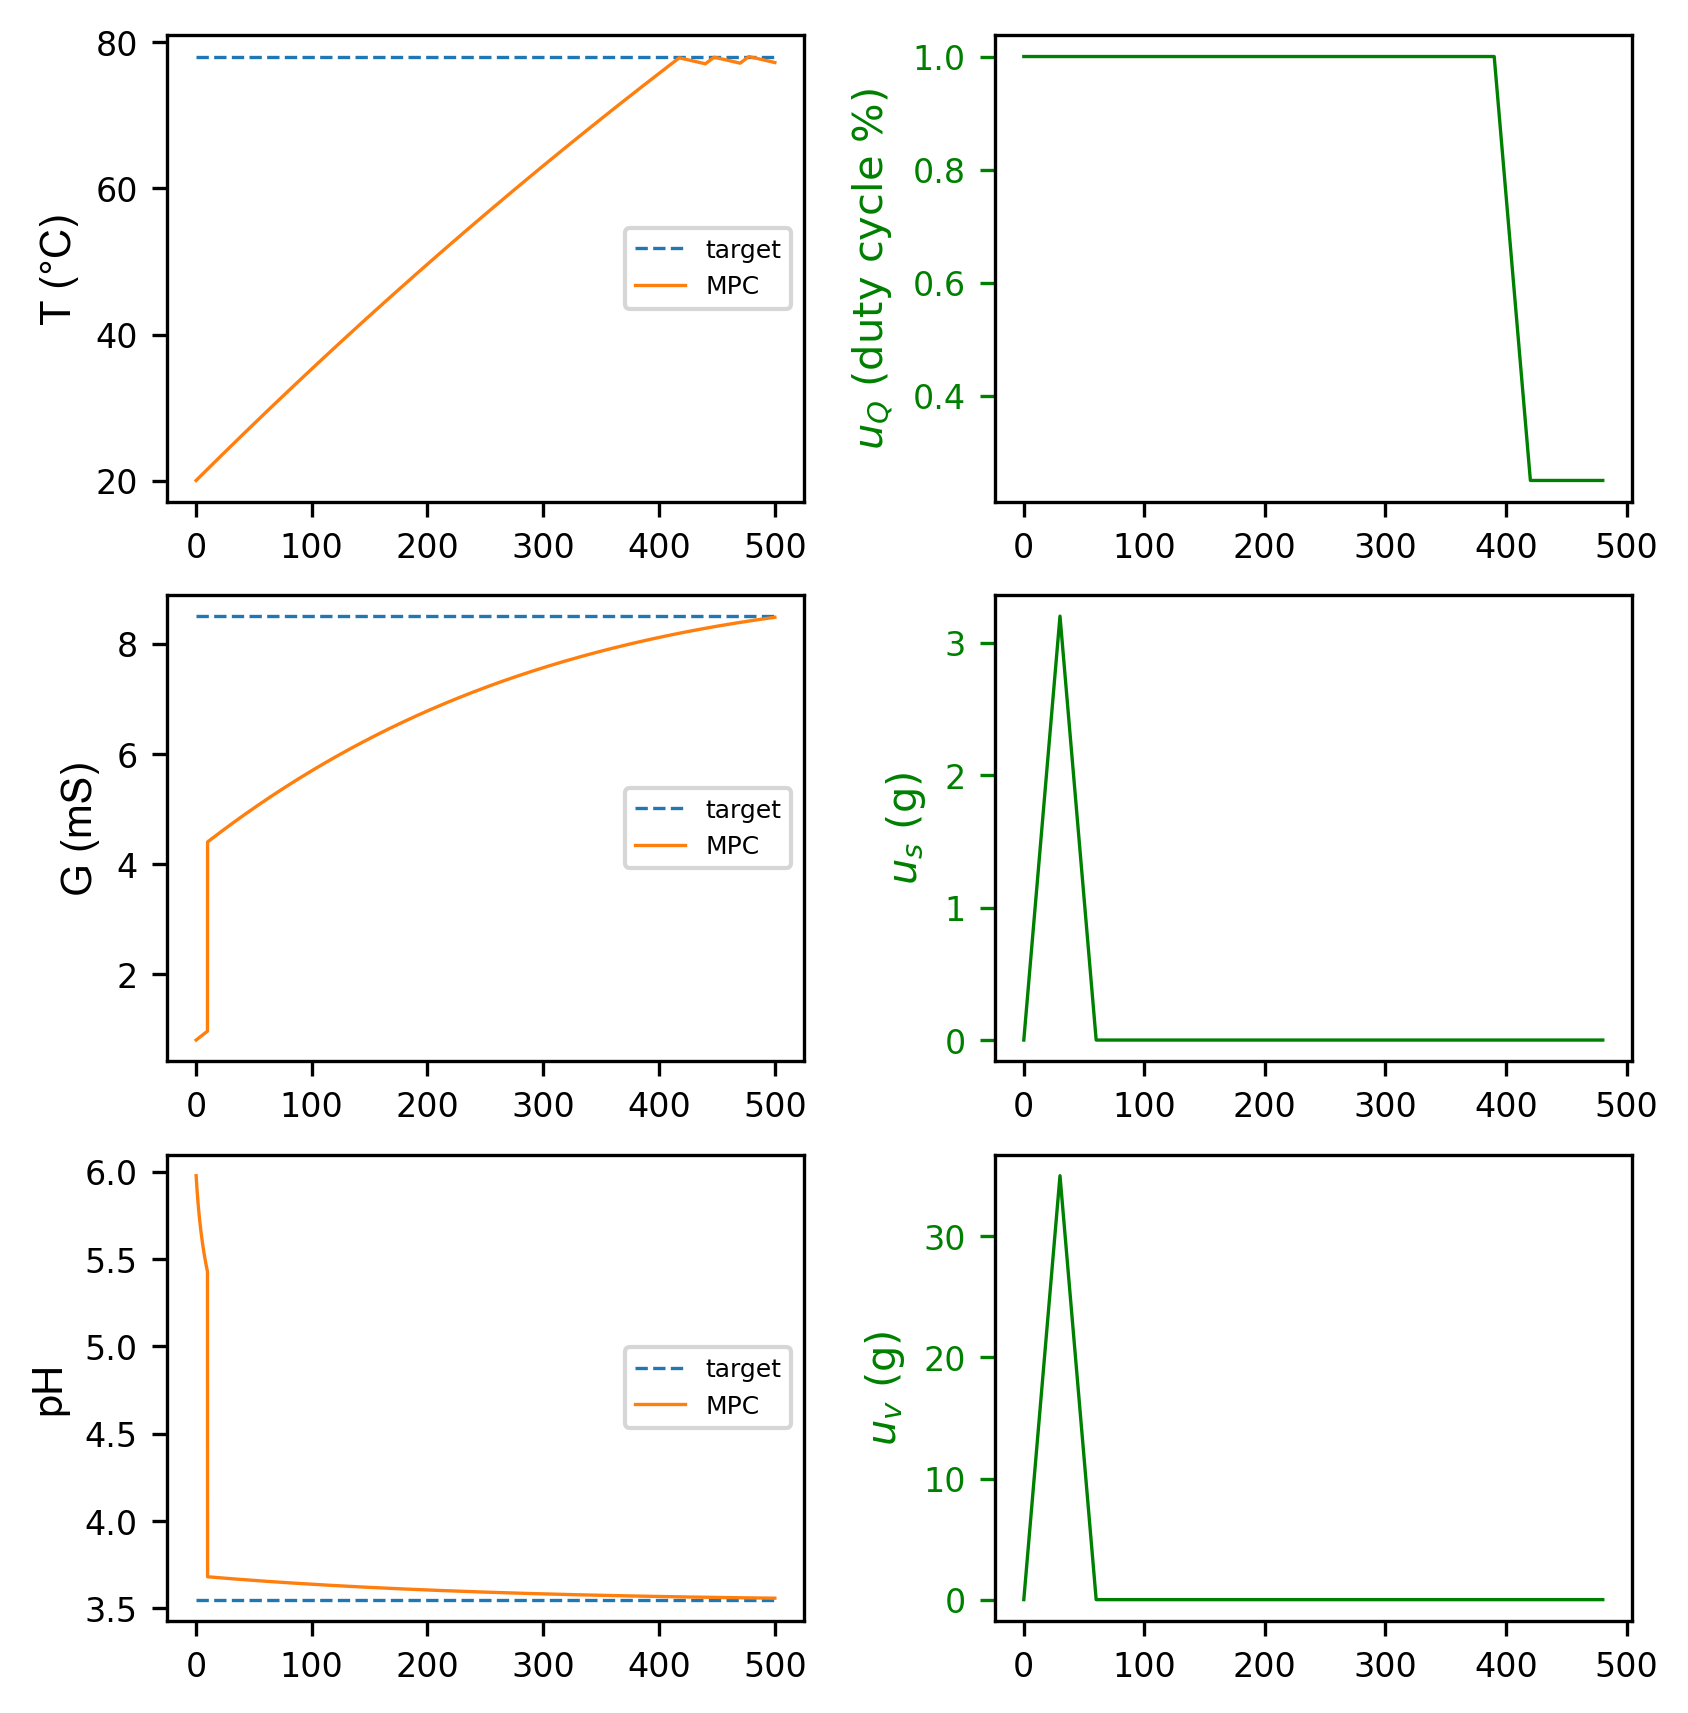

In [74]:
plotwidth = 0.8

fig, axs = plt.subplots(3, 2, figsize=(6.3, 7))

Q = np.array(4100*[1] + (75*[1] + 225*[0])*3)*4.88*2**7
Q_input_array = np.array([1]*14 + [0.25]*3)
index = np.array([10])
salt = np.array([3.2])
vinegar = np.array([3.5])

MPCData = simulationStandard(Q, index, salt, vinegar, 0.4)
t_MPC = MPCData[:,0]
T_MPC = MPCData[:,1]
G_MPC = MPCData[:,2]
pH_MPC = MPCData[:,3]

axs[0, 0].plot([0, 500], [78, 78], label = "target", linewidth = plotwidth, linestyle='--')
axs[0, 0].plot(t_MPC[1:], T_MPC[1:], label = "MPC", linewidth = plotwidth)
axs[0, 0].tick_params(axis='x', labelsize = tiny_fontsize)
axs[0, 0].tick_params(axis='y', labelsize = tiny_fontsize)
axs[0, 0].set_ylabel('T (°C)', **smaller_font)
axs[0, 0].legend(fontsize = tiny_fontsize - 2, loc = 'center right')
axs[0, 1].plot(t_MPC[1::300], Q_input_array, linewidth = plotwidth, color = "Green")
axs[0, 1].set_ylabel('$u_{Q}$ (duty cycle %)', color = "Green")
axs[0, 1].tick_params(axis='x', labelsize = tiny_fontsize)
axs[0, 1].tick_params(axis='y', colors = "Green", labelsize = tiny_fontsize)

axs[1, 0].plot([0, 500], [8.5, 8.5], label = "target", linewidth = plotwidth, linestyle='--')
axs[1, 0].plot(t_MPC[1:], G_MPC[1:]*1000, label = "MPC", linewidth = plotwidth)
axs[1, 0].tick_params(axis='x', labelsize = tiny_fontsize)
axs[1, 0].tick_params(axis='y', labelsize = tiny_fontsize)
axs[1, 0].set_ylabel('G (mS)', **smaller_font)
axs[1, 0].legend(fontsize = tiny_fontsize - 2, loc = 'center right')
axs[1, 1].plot(t_MPC[1::300], [0] + [salt[0]] + [0]*15, linewidth = plotwidth, color = "Green")
axs[1, 1].set_ylabel('$u_{s}$ (g)', color = "Green")
axs[1, 1].tick_params(axis='x', labelsize = tiny_fontsize)
axs[1, 1].tick_params(axis='y', colors = "Green", labelsize = tiny_fontsize)

axs[2, 0].plot([0, 500], [3.55, 3.55], label = "target", linewidth = plotwidth, linestyle='--')
axs[2, 0].plot(t_MPC[1:], pH_MPC[1:], label = "MPC", linewidth = plotwidth)
axs[2, 0].tick_params(axis='x', labelsize = tiny_fontsize)
axs[2, 0].tick_params(axis='y', labelsize = tiny_fontsize)
axs[2, 0].set_ylabel('pH', **smaller_font)
axs[2, 0].legend(fontsize = tiny_fontsize - 2, loc = 'center right')
axs[2, 1].plot(t_MPC[1::300], [0] + [vinegar[0]*10] + [0]*15, linewidth = plotwidth, color = "Green")
axs[2, 1].set_ylabel('$u_{v}$ (g)', color = "Green")
axs[2, 1].tick_params(axis='x', labelsize = tiny_fontsize)
axs[2, 1].tick_params(axis='y', colors = "Green", labelsize = tiny_fontsize)

plt.subplots_adjust(wspace=0.3)